In [2]:
import random
import sys
sys.path.append("../../../")
from simulation_classes.eta.car import Cars
from simulation_classes.eta.CWPTable import CWPTable
from simulation_classes.eta.SimulationClass import ETASimulation
sys.path.append("../")
from utils import find_delta_v_list, find_delta_x_list

In [9]:
# 初期設定（独立変数群）
CAR_NUM = 20 #時間窓内の車の総数
START_TIME = 0
TOTAL_LENGTH = 2000 # 入り口から出口までの距離 [m]
WAYPOINTS_NUM = 10 #constrained way pointの数
ORIFITH_LENGTH = 5 # 整流区間長さ. 最後のCWPのindexで指定。
MEAN_SPEED = 20 # 秒速[m/s]として定義
SCALE_FACTOR = 20 #シミュレーション上で距離を変換するための係数
TIME_STEP = 1
TOTAL_TIME = 100
V_MAX = 40

# ETAに関する設定
GLOBAL_TIME_WINDOW = 120  # Strategic Phaseでの時間幅
BATCH_NUM = 1
WINDOW_SIZE = (GLOBAL_TIME_WINDOW / BATCH_NUM)
DESIRED_TTC = 5 # 目標とする車間時間 [s]
DESIRED_SPEED = 21 # 目標とする出口速度 [m/s]

# 車のパラメータ
MAX_ACC_REAL_WORLD = 2 # 0.2Gくらい
MIN_ACC_REAL_WORLD = 2 # 0.5Gくらい
FRONT_BRAKE_REAL_WORLD = 8 # 0.8Gくらい

helly_params = {
    "max_accel":  MAX_ACC_REAL_WORLD,
    "min_accel": 2,
    "front_car_brake":FRONT_BRAKE_REAL_WORLD / SCALE_FACTOR,
    "rear_brake_acc":2,
    "response_time":0.5, #秒で入れる,
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.499,
    "T_des": 1.1,
    "isRss":False
  }

simulation_params = {"TOTAL_TIME": TOTAL_TIME, "TIME_STEP":TIME_STEP}

In [10]:
# 従属的に決まるもの
WAYPOINTS = [{"waypoint_idx": i, "x": TOTAL_LENGTH / WAYPOINTS_NUM * (i)} for i in range(WAYPOINTS_NUM+1)]
group_id = 0

arrival_times = sorted([random.uniform(0, GLOBAL_TIME_WINDOW) for _ in range(CAR_NUM)])
# arrival_times = [15.3, 27.1, 48.66, 54.83, 55.63]
CARS = [Cars(arrival_time=time, index=index, mean_speed=MEAN_SPEED, \
              helly_params=helly_params, group_id=group_id, order_in_group=index)
              for index, time in enumerate(arrival_times)]

In [11]:
# ETA割り当てのアルゴリズム
"""
KISS: 基本的には車のdesiredに合わせる、最初のWaypointからTTCの分だけ空ける
CONTROLLED: 全体最適になるように調整
"""
ALGORITHM_LIST = ["KISS", "CONTROLLED", ]

cwp_table_controlled = CWPTable(waypoints = WAYPOINTS, algorithm = ALGORITHM_LIST[1], \
                     global_params={"WINDOW_SIZE":WINDOW_SIZE, "START_TIME":START_TIME, "DESIRED_TTC":DESIRED_TTC, \
                                   "ORIFITH_EXIT_INDEX":ORIFITH_LENGTH, "DESIRED_SPEED": DESIRED_SPEED, "V_MAX":V_MAX})

cwp_table_simpler = CWPTable(waypoints = WAYPOINTS, algorithm = ALGORITHM_LIST[0], \
                     global_params={"WINDOW_SIZE":WINDOW_SIZE, "START_TIME":START_TIME, "DESIRED_TTC":DESIRED_TTC, \
                                   "ORIFITH_EXIT_INDEX":ORIFITH_LENGTH, "DESIRED_SPEED": DESIRED_SPEED, "V_MAX":V_MAX})

120.0
120.0


In [12]:
eta_simulation_controlled = ETASimulation(CARS=CARS, CWPTable=cwp_table_controlled, simulation_params=simulation_params)
eta_simulation_simpler = ETASimulation(CARS=CARS, CWPTable=cwp_table_simpler, simulation_params=simulation_params)

eta_simulation_simpler.conduct_simulation()
cwp_table_simpler = eta_simulation_simpler.cwp_table

eta_simulation_controlled.conduct_simulation()
cwp_table_controlled = eta_simulation_controlled.cwp_table

rc_c = eta_simulation_controlled.calc_rectification()
rc_s = (eta_simulation_simpler.calc_rectification())
expansion_c = eta_simulation_controlled.calc_expansion()
expansion_s = eta_simulation_simpler.calc_expansion()
print("【整流率】CONTROLLED: {0:.3f}, SIMPLER: {1:.3f} ".format(rc_c, rc_s))
print("【拡大率】CONTROLLED: {0:.3f}, SIMPLER: {1:.3f} ".format(expansion_c, expansion_s))

初回
{'is_possible': True, 'Reason': 'OK'}
出口到達時刻:  47.60126502480867
{'is_possible': True, 'Reason': 'OK'}
出口到達時刻:  52.60134925836456
{'is_possible': True, 'Reason': 'OK'}
出口到達時刻:  57.61817273541624
{'is_possible': False, 'Reason': 'Cannot Arrive in time'}
出口到達時刻:  75.90570135659766
{'is_possible': True, 'Reason': 'OK'}
出口到達時刻:  80.89662470065153
{'is_possible': True, 'Reason': 'OK'}
出口到達時刻:  85.87541336628868
{'is_possible': True, 'Reason': 'OK'}
出口到達時刻:  90.8568407082517
{'is_possible': True, 'Reason': 'OK'}
出口到達時刻:  95.8374321302956
{'is_possible': True, 'Reason': 'OK'}
出口到達時刻:  100.8651333802024
{'is_possible': True, 'Reason': 'OK'}
出口到達時刻:  105.86523450995352
{'is_possible': True, 'Reason': 'OK'}
出口到達時刻:  110.83256686383226
{'is_possible': True, 'Reason': 'OK'}
出口到達時刻:  115.83492549747227
{'is_possible': True, 'Reason': 'OK'}
出口到達時刻:  123.76701160021089
{'is_possible': True, 'Reason': 'OK'}
出口到達時刻:  128.76394682399953
{'is_possible': True, 'Reason': 'OK'}
出口到達時刻:  133.7456520869759

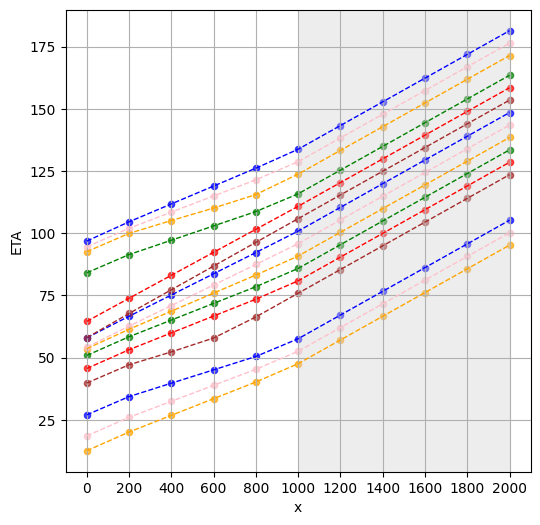

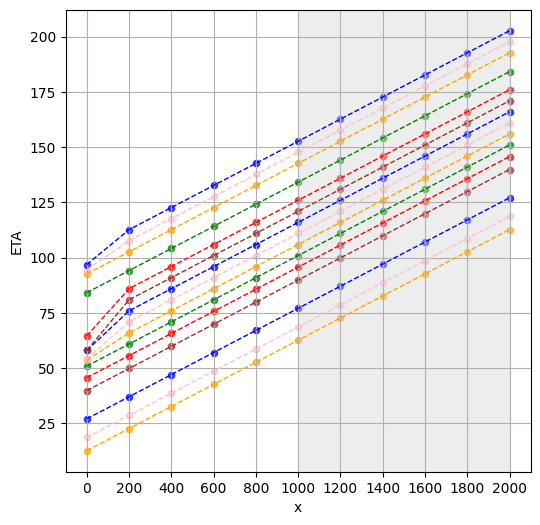

In [13]:
cwp_table_controlled.plot()
cwp_table_simpler.plot()

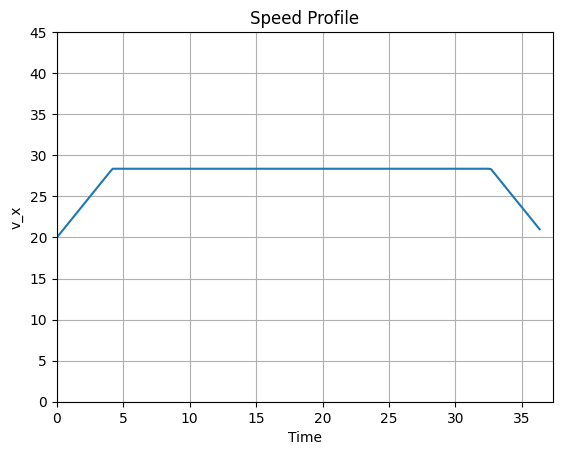

In [8]:
car = eta_simulation_controlled.CARS[8]
car.plot_speed_profile()